## Brain Tumor Detection with Neural Network

#### About the MRI image dataset
The dataset contains 2 folders 'Testing' and 'Training' and each folder contains 4 more folders for different categories of brain tumor each variant contains 115 - 74 images in them.

## Import Necessary Modules

In [1]:
import cv2
import os
import sklearn
import numpy as np
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [2]:
# Base path and labels
base_path = '../Dataset/'
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [3]:
# Constants
IMAGE_SIZE = 150
BATCH_SIZE = 12
VERBOSE = 1

Reading the dataset

In [4]:
x_train=[]
y_train=[]

# Loading Training Datasets from folders
for i in class_names:
    folderPath = os.path.join(os.path.join(base_path,'Training'),i)
    for j in tqdm(os.listdir(folderPath), ncols=70):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Training dataset Loading complete.')

# Loading Testing Datasets from folders
for i in class_names:
    folderPath = os.path.join(os.path.join(base_path, 'Testing'), i)
    for j in tqdm(os.listdir(folderPath), ncols=70):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Testing dataset Loading complete.')

x_train = np.array(x_train)
y_train = np.array(y_train)
x_train, y_train = sklearn.utils.shuffle(x_train, y_train, random_state=0)

100%|██████████████████████████████| 827/827 [00:07<00:00, 105.21it/s]


Training dataset Loading complete.


100%|█████████████████████████████████| 74/74 [00:00<00:00, 83.95it/s]


Testing dataset Loading complete.


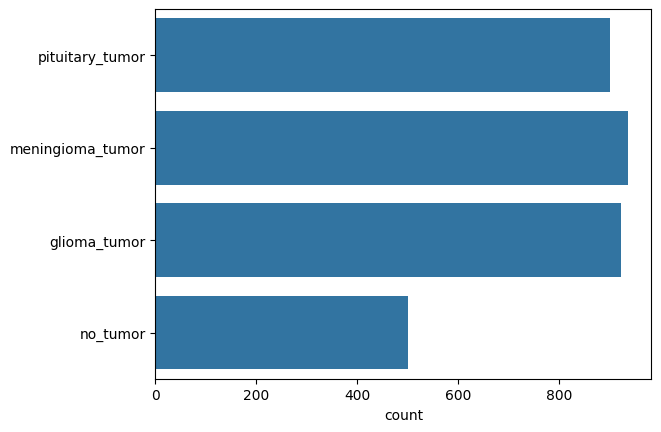

In [5]:
sns.countplot(y_train)
plt.show()

Sample of images in each class

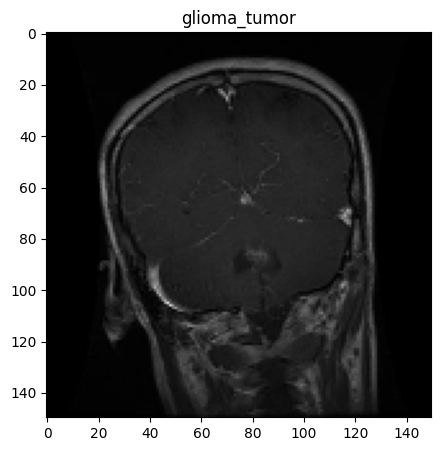

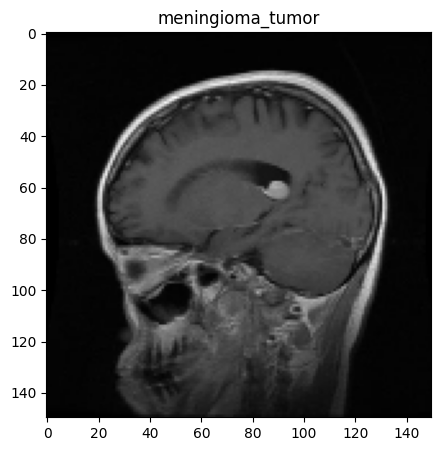

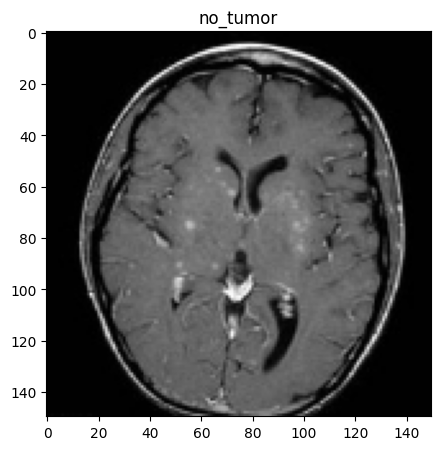

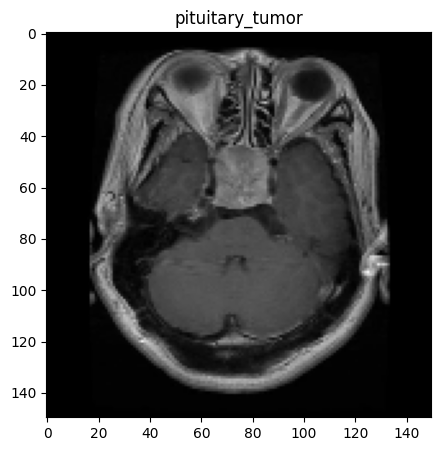

In [6]:
j=0
for i in class_names:
    j=0
    while True :
        if y_train[j]==i:
            plt.figure(figsize = (5,5))
            plt.imshow(x_train[j])
            plt.title(y_train[j])
            break
        j+=1

In [7]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	horizontal_flip=True, fill_mode="nearest")

In [8]:
# Split them into testing and training data
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, random_state=47, test_size=0.10)

print("Shapes X : Train :",x_train.shape,  " Test :",x_test.shape)
print("Shapes Y : Train :",y_train.shape,  " Test :",y_test.shape)

Shapes X : Train : (2934, 150, 150, 3)  Test : (327, 150, 150, 3)
Shapes Y : Train : (2934,)  Test : (327,)


Encoding the y_train and y_test to numbers

In [9]:
y_train_new = [class_names.index(i) for i in y_train]
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = [class_names.index(i) for i in y_test]
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [10]:
# Using the Xception Model
inputShape = (IMAGE_SIZE, IMAGE_SIZE, 3)
xception = Xception(weights="imagenet", input_shape=inputShape, include_top=False)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 33s 0us/step


In [11]:
# Adding the layers of Neural Network
model = xception.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs=xception.input, outputs=model)

Model summary

In [12]:
# Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 150, 150, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 74, 74, 32)        │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_bn               │ (None, 74, 74, 32)        │             128 │ block1_conv1[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_act (Activation) │ (None, 74, 74, 32)        │               0 │ block1_conv1_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 72, 72, 64)        │          18,432 │ block1_conv1_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_bn               │ (None, 72, 72, 64)        │             256 │ block1_conv2[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_act (Activation) │ (None, 72, 72, 64)        │               0 │ block1_conv2_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1               │ (None, 72, 72, 128)       │           8,768 │ block1_conv2_act[0][0]     │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1_bn            │ (None, 72, 72, 128)       │             512 │ block2_sepconv1[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_act           │ (None, 72, 72, 128)       │               0 │ block2_sepconv1_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2               │ (None, 72, 72, 128)       │          17,536 │ block2_sepconv2_act[0][0]  │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_bn            │ (None, 72, 72, 128)       │             512 │ block2_sepconv2[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 36, 36, 128)       │           8,192 │ block1_conv2_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 36, 36, 128)       │               

 Total params: 20,869,676 (79.61 MB)

 Trainable params: 20,815,148 (79.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [14]:
# Creating callbacks
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("xception.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=VERBOSE)

Training the model

In [15]:
# Compling and fitting the model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(aug.flow(x_train, y_train, batch_size=BATCH_SIZE),
	validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BATCH_SIZE,
	epochs=12, callbacks=[reduce_lr, checkpoint, tensorboard]) 

Epoch 1/12


C:\Users\praty\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6389 - loss: 0.9612
Epoch 1: val_accuracy improved from -inf to 0.82569, saving model to xception.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 594s 2s/step - accuracy: 0.6393 - loss: 0.9605 - val_accuracy: 0.8257 - val_loss: 0.7424 - learning_rate: 0.0010
Epoch 2/12
  1/244 ━━━━━━━━━━━━━━━━━━━━ 9:09 2s/step - accuracy: 0.7500 - loss: 0.7079

C:\Users\praty\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 2: val_accuracy did not improve from 0.82569
244/244 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.7500 - loss: 0.3554 - val_accuracy: 0.8073 - val_loss: 0.7067 - learning_rate: 0.0010
Epoch 3/12
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8376 - loss: 0.4658
Epoch 3: val_accuracy improved from 0.82569 to 0.91437, saving model to xception.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 555s 2s/step - accuracy: 0.8376 - loss: 0.4659 - val_accuracy: 0.9144 - val_loss: 0.2687 - learning_rate: 0.0010
Epoch 4/12
  1/244 ━━━━━━━━━━━━━━━━━━━━ 9:15 2s/step - accuracy: 0.8333 - loss: 0.4646
Epoch 4: val_accuracy improved from 0.91437 to 0.92049, saving model to xception.keras
244/244 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8333 - loss: 0.2332 - val_accuracy: 0.9205 - val_loss: 0.2763 - learning_rate: 0.0010
Epoch 5/12
244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8796 - loss: 0.3614
Epoch 5: val_accuracy did not improve from 0.92049
244/244 ━━━━━━━━━━━━━━━━━━━━ 554s 2s/s

Training, loss vs epoch.

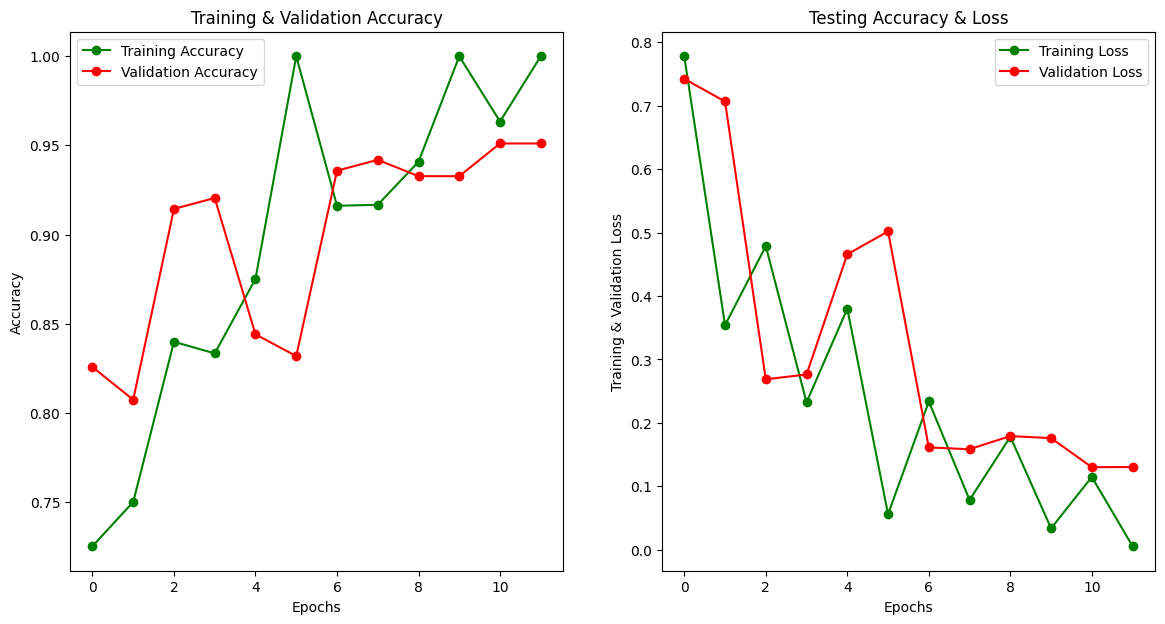

In [16]:
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(14, 7)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'g-o', label ='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.show()

Model performance

In [17]:
# Evaluating Model
result = model.evaluate(x_test, y_test)
print("Testing Loss :", result[0])
print("Testing Accuracy :", result[1]*100, "%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 742ms/step - accuracy: 0.9420 - loss: 0.1828
Testing Loss : 0.13040746748447418
Testing Accuracy : 95.10703086853027 %


In [18]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis = 1)
y_test_edit = np.argmax(y_test , axis = 1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 923ms/step


Classification Report

In [19]:
cf_report = sklearn.metrics.classification_report(y_test_edit, predictions)
print(cf_report)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       102
           1       0.97      0.89      0.93        87
           2       0.96      0.98      0.97        51
           3       0.96      0.98      0.97        87

    accuracy                           0.95       327
   macro avg       0.95      0.95      0.95       327
weighted avg       0.95      0.95      0.95       327



Confusion Matrix

<Axes: >

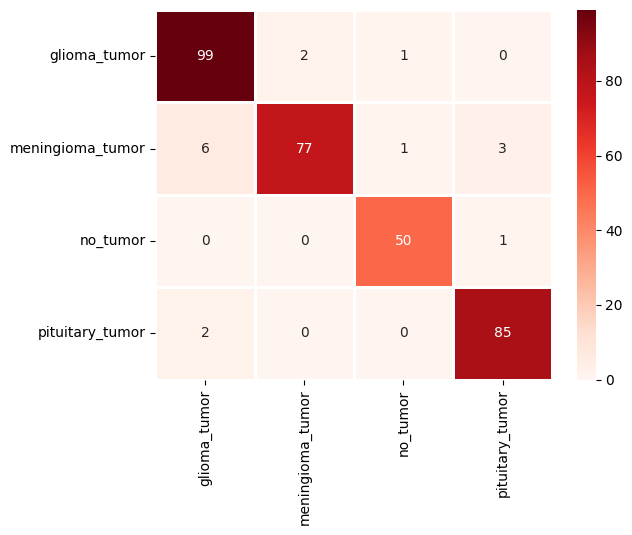

In [22]:
cf_matrix = sklearn.metrics.confusion_matrix(y_test_edit, predictions)
sns.heatmap(cf_matrix, cmap = 'Reds', linewidth = 1, annot = True, xticklabels=class_names, yticklabels=class_names)

In [27]:
model.save('myModel.h5')